C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_19984\1024036623.py:71: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[Y == class_value].index, [-0.5] * len(X[Y == class_value]), c=colors[i], label=str(class_value), alpha=0.6, edgecolors='none')
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_19984\1024036623.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(train_index, [ii + offset] * len(tr

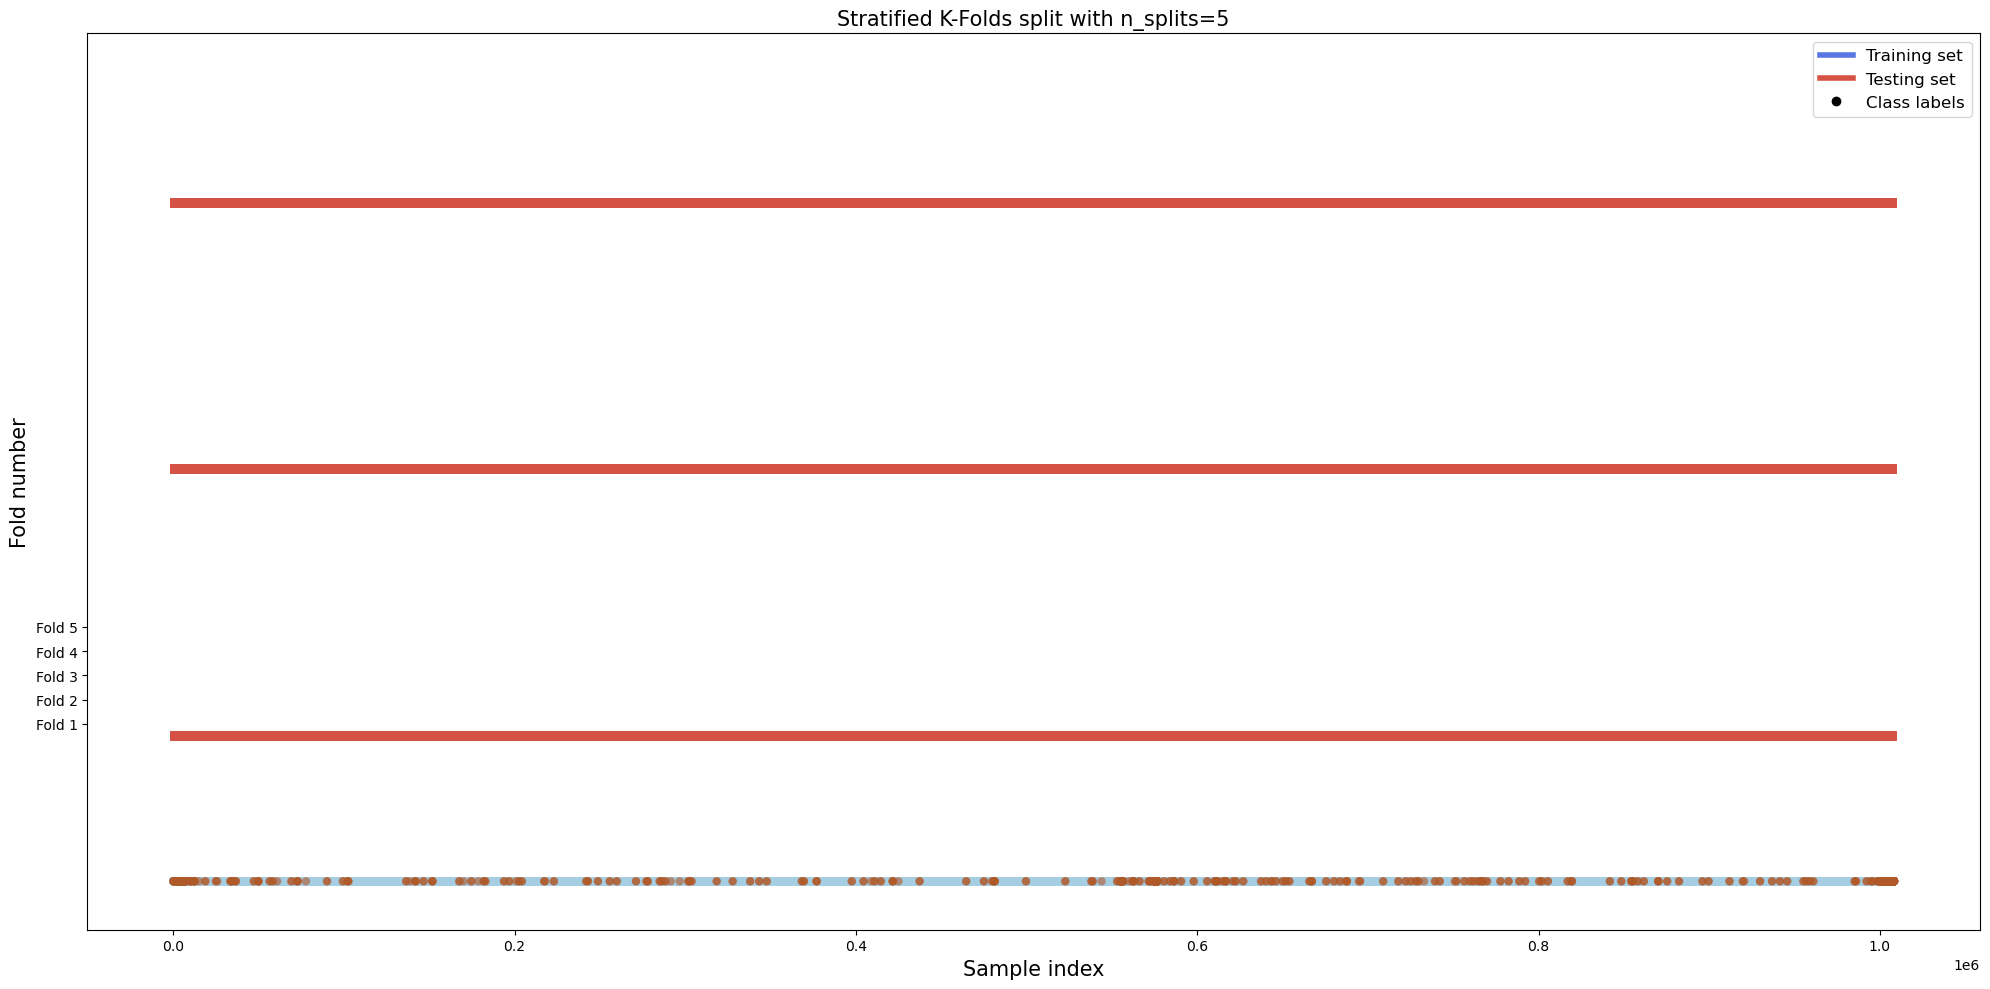

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import average_precision_score, classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load dataset
df = pd.read_csv("../card_credit_fraud.csv")
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

df['nameOrig'] = df['nameOrig'].str.replace('C', '0', regex=False)
df['nameOrig'] = df['nameOrig'].str.replace('M', '1', regex=False)

df['nameDest'] = df['nameDest'].str.replace('C', '0', regex=False)
df['nameDest'] = df['nameDest'].str.replace('M', '1', regex=False)

df['nameOrig'] = df['nameOrig'].astype('category').cat.codes
df['nameDest'] = df['nameDest'].astype('category').cat.codes

Y = df['isFraud']
X = df.drop(['isFraud'], axis=1)

X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.loc[X.type == 'PAYMENT', 'type'] = 2
X.loc[X.type == 'CASH_IN', 'type'] = 3
X.loc[X.type == 'DEBIT', 'type'] = 4

X.type = X.type.astype(int)


# Split the dataset (Note: We split before resampling to avoid data leakage)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.3, random_state=42)

# Define the pipeline with SMOTE and XGBClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [1, 3, 5, 7, 10],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__scale_pos_weight': [1, (Y == 0).sum() / (Y == 1).sum()]  # Adjust for imbalance
}

# Configure GridSearchCV
n_splits = 5
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Determine class proportions in each fold
class_counts = np.unique(Y, return_counts=True)[1]
class_labels = np.unique(Y)
n_classes = len(class_labels)

train_class_proportions = np.zeros((n_splits, n_classes))
test_class_proportions = np.zeros((n_splits, n_classes))

for i, (train_idx, test_idx) in enumerate(cv.split(X, Y)):
    y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    for j, label in enumerate(class_labels):
        train_class_proportions[i, j] = np.sum(y_train == label) / len(y_train)
        test_class_proportions[i, j] = np.sum(y_test == label) / len(y_test)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each class
colors = plt.cm.Dark2(np.linspace(0, 1, n_classes))

# Plot for each class
bottom_train = np.zeros(n_splits)
bottom_test = np.zeros(n_splits)
for j, label in enumerate(class_labels):
    ax.bar(np.arange(n_splits) - 0.15, train_class_proportions[:, j], color=colors[j], width=0.3, label=f'Class {label} - Train', bottom=bottom_train)
    bottom_train += train_class_proportions[:, j]
    
    ax.bar(np.arange(n_splits) + 0.15, test_class_proportions[:, j], color=colors[j], width=0.3, label=f'Class {label} - Test', bottom=bottom_test, hatch='//')
    bottom_test += test_class_proportions[:, j]

ax.set_xlabel('Fold Number')
ax.set_ylabel('Proportion')
ax.set_title('Class Proportions in Training and Testing Sets for Each Fold')
ax.set_xticks(np.arange(n_splits))
ax.set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
ax.legend()

plt.tight_layout()
plt.show()